# 0. Imports & functions

In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/telco_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
# df = pd.read_csv(RAW_DATA_PATH)
# df = df.rename(columns=dict(
#     zip(df.columns, list(map(to_snake_case, df.columns)))))

# print(df.shape[0])
# df.churn.value_counts()/df.shape[0]*100

In [4]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv','streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category","churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [5]:
pd.set_option('display.max_columns', None)

# df.internet_type.isna().sum()
df.head()


,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


# 2. Model selection

## Logistic Regression

In [6]:
df[y].value_counts()/len(df)

customer_status
Stayed     0.716345
Churned    0.283655
Name: count, dtype: float64

In [7]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
    
}

model = LogisticRegression()

MODEL_NAME = "logistic"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name=MODEL_NAME, param_grid=param_grid, verbose=1,
   )
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1260 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^

Best score: 0.9141591902461468
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.7, 'pca__n_components': 65, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'streaming_music',
                                                   'unlimited_data', 'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=0.7)),
                ('pca', PCA(n_components=65)),
                ('logistic', LogisticRegression(C=100))])

In [8]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [9]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
29,0.5,0.7,15,1,l2,0.874219,0.007253
113,0.5,0.7,15,10,l2,0.874426,0.006936
197,0.5,0.7,15,100,l2,0.874229,0.008014
281,0.5,0.7,15,1000,l2,0.873951,0.007729
33,0.5,0.7,20,1,l2,0.874989,0.007380
...,...,...,...,...,...,...,...
330,0.7,1.0,50,1000,l2,0.913213,0.005725
82,0.7,1.0,65,1,l2,0.913214,0.006895
166,0.7,1.0,65,10,l2,0.912010,0.007431
250,0.7,1.0,65,100,l2,0.913497,0.005807


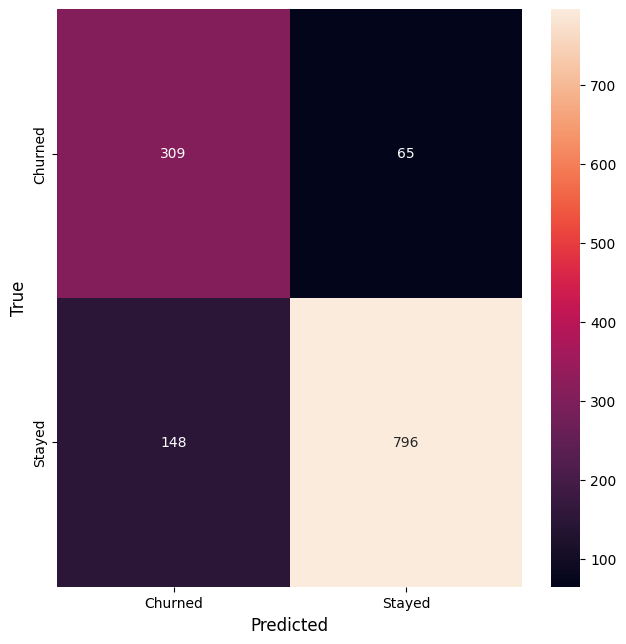

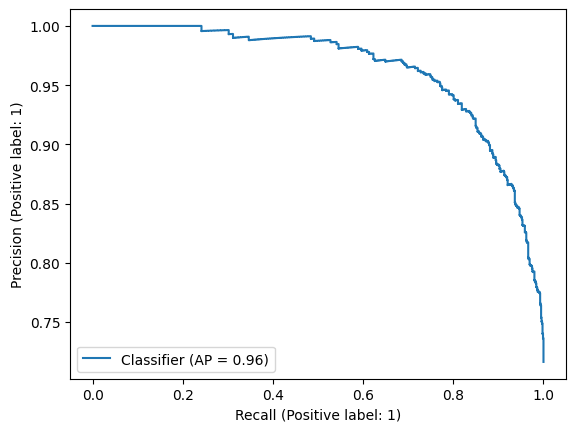

In [10]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [11]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8937074197943764
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 15, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [12]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

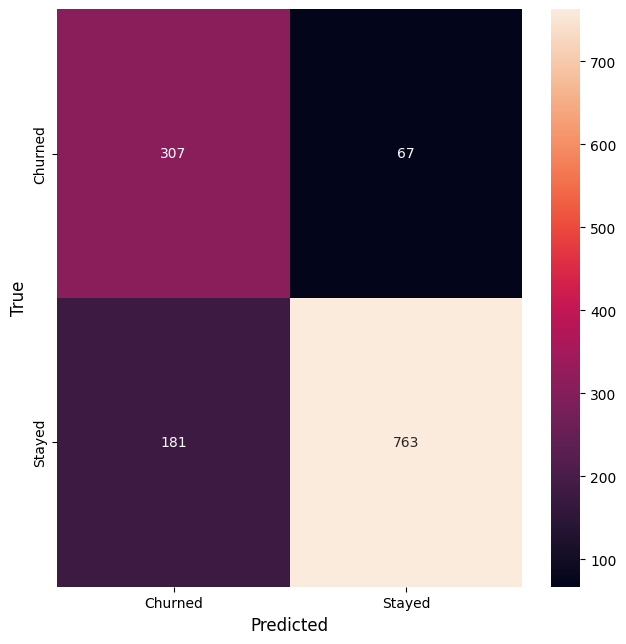

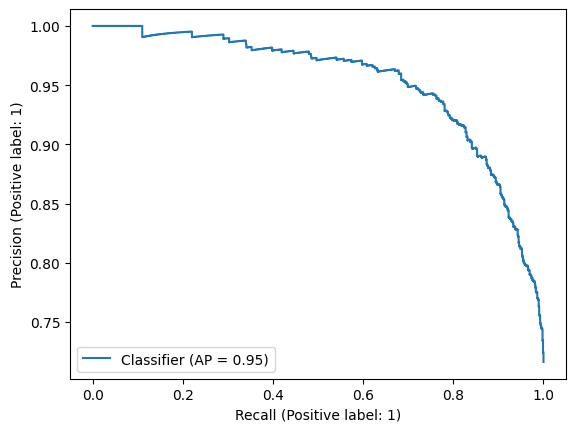

In [13]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [14]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# 3. Cost-based evaluation

In [15]:
TRUE_Y_ENCODED_COLUMN_NAME = "churn_encoded"
PREDICTED_Y_PROB_COLUMN_NAME_PREFIX = "y_predicted_proba"

In [16]:

MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log[predicted_y_prob_col_name_log]= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
test_predictions_log[predicted_y_prob_col_name_log] = 1 - test_predictions_log[predicted_y_prob_col_name_log]
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log["customer_status"])
test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["monthly_charge"]).to_frame())[:, 0]
test_predictions_log["y_predicted"] = 1 - test_predictions_log["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))



Test cost/loss = 73812.
 total cost/loss average :  56.00295902883156


In [17]:


MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb[predicted_y_prob_col_name_xgb]
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb["customer_status"])
test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb["y_predicted"] =  1- test_predictions_xgb["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))



Test cost/loss = 78417.
 total cost/loss average :  59.49696509863429


In [18]:
print(test_predictions_xgb[['customer_status', "A", 'instance_cost', "y_predicted"]].head(30))

     customer_status       A  instance_cost  y_predicted
4879          Stayed   67.45            0.0            0
1646          Stayed   69.65            0.0            0
777           Stayed   20.10            0.0            0
1163          Stayed   54.75            0.0            0
130           Stayed   48.80            0.0            0
3765         Churned   80.35          964.2            0
2533         Churned   75.30            0.0            1
1837          Stayed   19.90            0.0            0
302           Stayed   20.05            0.0            0
768           Stayed   39.40            0.0            0
1695         Churned   91.00         1092.0            0
1366         Churned   49.05          588.6            0
1058          Stayed   99.00            0.0            0
2474         Churned   86.20            0.0            1
1141          Stayed   19.80            0.0            0
2348          Stayed   19.95            0.0            0
2971         Churned   79.65   

# 3.1 AMC evaluation metric

In [19]:
test_predictions_log[predicted_y_prob_col_name_log]

4879    0.242989
1646    0.028408
777     0.066300
1163    0.069645
130     0.022725
          ...   
5340    0.174352
2641    0.904073
5796    0.920578
36      0.673123
5716    0.125737
Name: y_predicted_proba_log, Length: 1318, dtype: float64

In [20]:
test_predictions_log['A']

4879     67.45
1646     69.65
777      20.10
1163     54.75
130      48.80
         ...  
5340    105.05
2641     88.15
5796     94.10
36       89.80
5716     49.45
Name: A, Length: 1318, dtype: float64

Decision Threshold: 0.01, Test cost/loss = 94230.70
Decision Threshold: 0.02, Test cost/loss = 86300.50
Decision Threshold: 0.03, Test cost/loss = 79021.00
Decision Threshold: 0.04, Test cost/loss = 74771.80
Decision Threshold: 0.05, Test cost/loss = 70854.40
Decision Threshold: 0.06, Test cost/loss = 69912.20
Decision Threshold: 0.07, Test cost/loss = 67958.20
Decision Threshold: 0.08, Test cost/loss = 66525.10


Decision Threshold: 0.09, Test cost/loss = 67754.70
Decision Threshold: 0.10, Test cost/loss = 65637.30
Decision Threshold: 0.11, Test cost/loss = 64250.80
Decision Threshold: 0.12, Test cost/loss = 62782.50
Decision Threshold: 0.13, Test cost/loss = 62186.60
Decision Threshold: 0.14, Test cost/loss = 61446.20
Decision Threshold: 0.15, Test cost/loss = 60506.70
Decision Threshold: 0.16, Test cost/loss = 62581.30
Decision Threshold: 0.17, Test cost/loss = 62381.50
Decision Threshold: 0.18, Test cost/loss = 60646.80
Decision Threshold: 0.19, Test cost/loss = 60295.60
Decision Threshold: 0.20, Test cost/loss = 58272.40
Decision Threshold: 0.21, Test cost/loss = 57399.40
Decision Threshold: 0.22, Test cost/loss = 57557.40
Decision Threshold: 0.23, Test cost/loss = 58150.10
Decision Threshold: 0.24, Test cost/loss = 58044.90
Decision Threshold: 0.25, Test cost/loss = 56711.90
Decision Threshold: 0.26, Test cost/loss = 58830.00
Decision Threshold: 0.27, Test cost/loss = 58345.70
Decision Thr

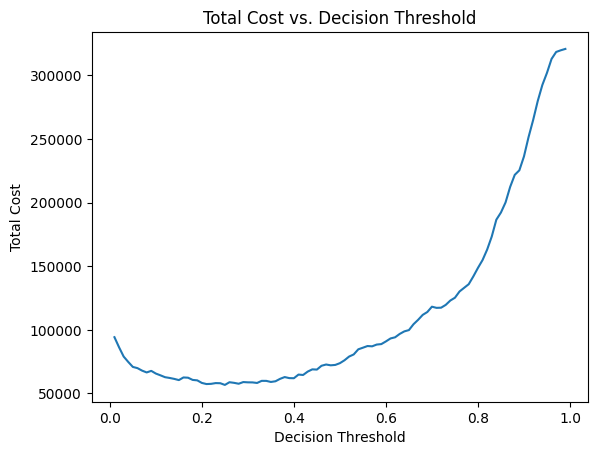

In [21]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(
    test=test_predictions_log, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log)

Decision Threshold: 0.01, Test cost/loss = 104193.20
Decision Threshold: 0.02, Test cost/loss = 97353.90
Decision Threshold: 0.03, Test cost/loss = 90753.60
Decision Threshold: 0.04, Test cost/loss = 88700.10
Decision Threshold: 0.05, Test cost/loss = 84487.10
Decision Threshold: 0.06, Test cost/loss = 80597.20
Decision Threshold: 0.07, Test cost/loss = 78629.80
Decision Threshold: 0.08, Test cost/loss = 78826.50
Decision Threshold: 0.09, Test cost/loss = 76414.90
Decision Threshold: 0.10, Test cost/loss = 73304.30
Decision Threshold: 0.11, Test cost/loss = 71951.90
Decision Threshold: 0.12, Test cost/loss = 71657.00
Decision Threshold: 0.13, Test cost/loss = 70391.60
Decision Threshold: 0.14, Test cost/loss = 68468.00
Decision Threshold: 0.15, Test cost/loss = 69278.20
Decision Threshold: 0.16, Test cost/loss = 69050.10
Decision Threshold: 0.17, Test cost/loss = 68670.70
Decision Threshold: 0.18, Test cost/loss = 68164.50
Decision Threshold: 0.19, Test cost/loss = 67166.20
Decision Th

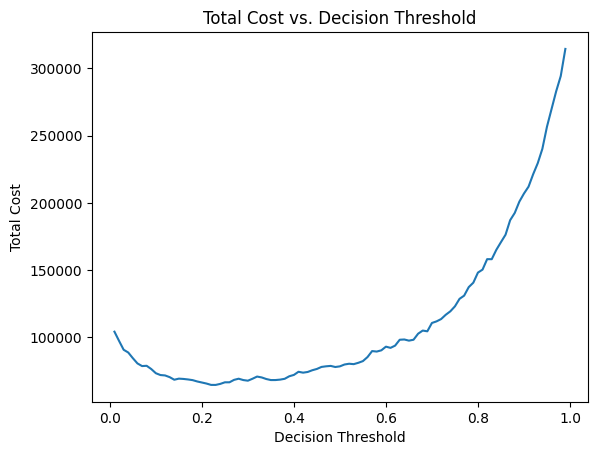

In [22]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(
    test=test_predictions_xgb, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb)

# 3.2 E-AMC evaluation metric


In [23]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [24]:
test_predictions_log

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,y_predicted,y_predicted_proba_log,churn_encoded,A,instance_cost,y_predicted_decoded,TN,FN,FP,TP,EAP,EP
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,0,0.242989,0,67.45,0.0,Churned,0,809.4,134.9,0,32.779207,38.261336
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,0,0.028408,0,69.65,0.0,Churned,0,835.8,139.3,0,3.957243,39.509296
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,0,0.066300,0,20.10,0.0,Churned,0,241.2,40.2,0,2.665244,11.401821
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,0,0.069645,0,54.75,0.0,Churned,0,657.0,109.5,0,7.626112,31.057200
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,0,0.022725,0,48.80,0.0,Churned,0,585.6,97.6,0,2.217924,27.682034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Female,44,Yes,0,93437,1,20,NaN,No,0.00,no phone service,Yes,DSL,10.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,24.45,482.80,0.0,0,0.00,482.80,Churned,1,0.806974,1,24.45,293.4,Stayed,0,293.4,48.9,0,56.633800,210.183722
2993,Male,54,Yes,0,93637,1,40,Offer B,Yes,22.56,Yes,Yes,Cable,4.0,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,101.30,4113.10,0.0,0,902.40,5015.50,Churned,1,0.948513,1,101.30,1215.6,Stayed,0,1215.6,202.6,0,62.587320,870.822538
3373,Female,64,Yes,0,92320,1,1,Offer E,Yes,21.65,No,Yes,Fiber Optic,13.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,68.95,68.95,0.0,0,21.65,90.60,Churned,1,0.973663,1,68.95,827.4,Stayed,0,827.4,137.9,0,21.790845,592.726693
4476,Female,54,No,0,91202,0,1,Offer E,No,0.00,no phone service,Yes,DSL,27.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,29.95,29.95,0.0,0,0.00,29.95,Churned,1,0.853459,1,29.95,359.4,Stayed,0,359.4,59.9,0,52.666929,257.464314


In [25]:
test[y].value_counts()

customer_status
Stayed     944
Churned    374
Name: count, dtype: int64

In [26]:
test_predictions_xgb[y].value_counts()

customer_status
Stayed     944
Churned    374
Name: count, dtype: int64

In [27]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

112649.93051603771
263426.64964902296
EAP :  85.47035699244135
EP :  199.86847469576855


In [28]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

111008.42520492076
263426.64964902296
EAP :  84.2249053148109
EP :  199.86847469576855


# 3.3 EMP and MP evaluation metric

# non instanced based emp and mp (outside of the scope for our thesis)


In [29]:
df['total_revenue'].mean()

3235.2180816512373

In [30]:
# test_xgb = test.copy(deep=True)
# test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
# test_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_xgb["customer_status"])
# def __empRocInfo(probability_scores, true_class_labels):
    
#     # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
#     arguments_list = [test_xgb['y_predicted_proba'], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME]]
#     factor_array = []
#     n_0 = 0
#     number_of_factors = 0
    
#     def linear_line(m, x, b):
#         return m*x + b
    
    
#     for i in range(0, len(arguments_list)):
#         if (type(arguments_list[i]) == pd.Series):
#             arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
#         if (type(arguments_list[i]) == np.matrix):
#             arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
#         if (type(arguments_list[i]) == list):
#             arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] not in factor_array):
#             factor_array.append(arguments_list[1][i])
#             number_of_factors = number_of_factors + 1
            
#     if (number_of_factors > 2):
#         sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


#     ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

#     if (len(arguments_list[0]) != len(arguments_list[1])):
#         sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

# ### Checking that there are no invalid probabilities in the probability scores array ###

#     for i in range(0, len(arguments_list[0])):
#         if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
#             sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

# ### Counting the number of positive cases in the true class values array ###

#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] == 1):
#             n_0 +=  1
            
# ### Calculating metrics ###

#     total_number_of_observations = len(arguments_list[1])
#     n_1 = total_number_of_observations - n_0
#     pi_1 = n_1 / total_number_of_observations
#     pi_0 = n_0 / total_number_of_observations
#     fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
#     roc_output = np.c_[fpr, tpr]
#     hull = ConvexHull(roc_output)
#     vertices = []
    
#     for k in hull.vertices:
#         if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
#             vertices.append(k)
            
#     F_1 = roc_output[vertices, 0]
#     F_1 = np.sort(F_1)
#     F_0 = roc_output[vertices, 1]
#     F_0 = np.sort(F_0)
    
#     return n_0, n_1, pi_0, pi_1, F_0, F_1




In [31]:

# test_xgb = test.copy(deep=True)
# test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
# test_xgb[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_xgb["customer_status"])

# def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
#     def B(a, b, X):
        
        
#         return betainc(a, b, X)* ss.beta(a, b)

#         ### Initializing constants and variables for rest of function ###

#     roc = __empRocInfo(test["y_predicted_proba"], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME])
#     E_GAMMA = alpha / (alpha + beta)
#     DELTA = d / clv
#     PHI = f / clv
        
#     ### Calculating MP and MP fraction ###
#     '''
#     n_0, n_1, pi_0, pi_1, F_0, F_1
#     gamma values = pi_0 (delta * phi)
#     '''
#     gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
#     gamma_values = np.append(gamma_values[gamma_values < 1], 1)
#     ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
#     MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
#     MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

#     ### Calculating EMP and EMP fraction ###

#     gammaii = gamma_values[range(0, len(gamma_values) - 1)]
#     gammaie = gamma_values[range(1, len(gamma_values))]
#     F_0 = (roc[4])[range(0, len(gammaii))]
#     F_1 = (roc[5])[range(0, len(gammaii))]
#     contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
#     contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
#     EMP = np.sum(contr_0 + contr_1)
#     EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

#     ### Formatting output ###

#     if rounding != None:
#         MP = np.round(MP, decimals = rounding)
#         MP_fraction = np.round(MP_fraction, decimals = rounding)
#         EMP = np.round(EMP, decimals = rounding)
#         EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
#     output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
#     output = output(MP, MP_fraction, EMP, EMP_fraction)
        
#     if print_output:
#         print("******************************************************************************")
#         print("EMP Churn Output")
#         print("******************************************************************************")
#         print("MP: ", MP)
#         print("")
#         print("MP Fraction: ", MP_fraction)
#         print("")
#         print("EMP: ", EMP)
#         print("")
#         print("EMP Fraction: ", EMP_fraction)

    
            
#     if return_output:
#         return output

# empChurn(test_xgb["y_predicted_proba"], test_xgb[TRUE_Y_ENCODED_COLUMN_NAME], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)


In [32]:
# test = test.copy(deep=True)
# test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
# test[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test["customer_status"])
# def __empRocInfo(probability_scores, true_class_labels):
    
#     # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
#     arguments_list = [test['y_predicted_proba'], test[TRUE_Y_ENCODED_COLUMN_NAME]]
#     factor_array = []
#     n_0 = 0
#     number_of_factors = 0
    
#     def linear_line(m, x, b):
#         return m*x + b
    
    
#     for i in range(0, len(arguments_list)):
#         if (type(arguments_list[i]) == pd.Series):
#             arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
#         if (type(arguments_list[i]) == np.matrix):
#             arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
#         if (type(arguments_list[i]) == list):
#             arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] not in factor_array):
#             factor_array.append(arguments_list[1][i])
#             number_of_factors = number_of_factors + 1
            
#     if (number_of_factors > 2):
#         sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


#     ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

#     if (len(arguments_list[0]) != len(arguments_list[1])):
#         sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

# ### Checking that there are no invalid probabilities in the probability scores array ###

#     for i in range(0, len(arguments_list[0])):
#         if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
#             sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

# ### Counting the number of positive cases in the true class values array ###

#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] == 1):
#             n_0 +=  1
            
# ### Calculating metrics ###

#     total_number_of_observations = len(arguments_list[1])
#     n_1 = total_number_of_observations - n_0
#     pi_1 = n_1 / total_number_of_observations
#     pi_0 = n_0 / total_number_of_observations
#     fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
#     roc_output = np.c_[fpr, tpr]
#     hull = ConvexHull(roc_output)
#     vertices = []
    
#     for k in hull.vertices:
#         if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
#             vertices.append(k)
            
#     F_1 = roc_output[vertices, 0]
#     F_1 = np.sort(F_1)
#     F_0 = roc_output[vertices, 1]
#     F_0 = np.sort(F_0)
    
#     return n_0, n_1, pi_0, pi_1, F_0, F_1

In [33]:
# test = test.copy(deep=True)
# test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
# test[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test["customer_status"])

# def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
#     def B(a, b, X):
        
        
#         return betainc(a, b, X)* ss.beta(a, b)

#         ### Initializing constants and variables for rest of function ###

#     roc = __empRocInfo(test["y_predicted_proba"], test[TRUE_Y_ENCODED_COLUMN_NAME])
#     E_GAMMA = alpha / (alpha + beta)
#     DELTA = d / clv
#     PHI = f / clv
        
#     ### Calculating MP and MP fraction ###
#     '''
#     n_0, n_1, pi_0, pi_1, F_0, F_1
#     gamma values = pi_0 (delta * phi)
#     '''
#     gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
#     gamma_values = np.append(gamma_values[gamma_values < 1], 1)
#     ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
#     MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
#     MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

#     ### Calculating EMP and EMP fraction ###

#     gammaii = gamma_values[range(0, len(gamma_values) - 1)]
#     gammaie = gamma_values[range(1, len(gamma_values))]
#     F_0 = (roc[4])[range(0, len(gammaii))]
#     F_1 = (roc[5])[range(0, len(gammaii))]
#     contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
#     contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
#     EMP = np.sum(contr_0 + contr_1)
#     EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

#     ### Formatting output ###

#     if rounding != None:
#         MP = np.round(MP, decimals = rounding)
#         MP_fraction = np.round(MP_fraction, decimals = rounding)
#         EMP = np.round(EMP, decimals = rounding)
#         EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
#     output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
#     output = output(MP, MP_fraction, EMP, EMP_fraction)
        
#     if print_output:
#         print("******************************************************************************")
#         print("EMP Churn Output")
#         print("******************************************************************************")
#         print("MP: ", MP)
#         print("")
#         print("MP Fraction: ", MP_fraction)
#         print("")
#         print("EMP: ", EMP)
#         print("")
#         print("EMP Fraction: ", EMP_fraction)

    
            
#     if return_output:
#         return output

# empChurn(test["y_predicted_proba"], test[TRUE_Y_ENCODED_COLUMN_NAME], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)

# MP metric at 50% threshold

In [34]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_2 = test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
test_predictions_log_2[predicted_y_prob_col_name_log] = 1 - test_predictions_log_2[predicted_y_prob_col_name_log]
test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_2["customer_status"])
test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_2[TRUE_Y_ENCODED_COLUMN_NAME]
# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["monthly_charge"]).to_frame())[:, 0]
test_predictions_log_2["y_predicted"] = 1 - test_predictions_log_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -29015.
 total cost/loss average :  -22.01433990895296


In [35]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
test_predictions_xgb_2[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_2[predicted_y_prob_col_name_xgb]
test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_2["customer_status"])
test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_2[TRUE_Y_ENCODED_COLUMN_NAME]
# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb_2["y_predicted"] = 1 - test_predictions_xgb_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -33477.
 total cost/loss average :  -25.399924127465862


# MP metric

Decision Threshold: 0.01, Test cost/loss = -40815.20
Decision Threshold: 0.02, Test cost/loss = -33232.00
Decision Threshold: 0.03, Test cost/loss = -25952.50
Decision Threshold: 0.04, Test cost/loss = -21703.30
Decision Threshold: 0.05, Test cost/loss = -17785.90
Decision Threshold: 0.06, Test cost/loss = -17116.40
Decision Threshold: 0.07, Test cost/loss = -15162.40
Decision Threshold: 0.08, Test cost/loss = -13837.70
Decision Threshold: 0.09, Test cost/loss = -15433.80
Decision Threshold: 0.10, Test cost/loss = -13316.40
Decision Threshold: 0.11, Test cost/loss = -11929.90
Decision Threshold: 0.12, Test cost/loss = -10461.60


Decision Threshold: 0.13, Test cost/loss = -9976.20
Decision Threshold: 0.14, Test cost/loss = -9422.30
Decision Threshold: 0.15, Test cost/loss = -8591.10
Decision Threshold: 0.16, Test cost/loss = -11061.60
Decision Threshold: 0.17, Test cost/loss = -11026.60
Decision Threshold: 0.18, Test cost/loss = -9291.90
Decision Threshold: 0.19, Test cost/loss = -9108.80
Decision Threshold: 0.20, Test cost/loss = -7085.60
Decision Threshold: 0.21, Test cost/loss = -6212.60
Decision Threshold: 0.22, Test cost/loss = -6583.60
Decision Threshold: 0.23, Test cost/loss = -7433.70
Decision Threshold: 0.24, Test cost/loss = -7526.50
Decision Threshold: 0.25, Test cost/loss = -6193.50
Decision Threshold: 0.26, Test cost/loss = -8826.40
Decision Threshold: 0.27, Test cost/loss = -8431.80
Decision Threshold: 0.28, Test cost/loss = -7729.10
Decision Threshold: 0.29, Test cost/loss = -9323.30
Decision Threshold: 0.30, Test cost/loss = -9105.00
Decision Threshold: 0.31, Test cost/loss = -9221.10
Decision T

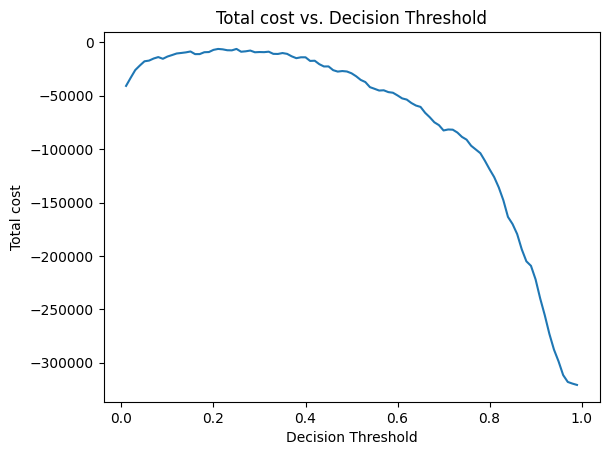

In [36]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(
    test=test_predictions_log_2, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'churn_2')

Decision Threshold: 0.01, Test cost/loss = -50916.20


Decision Threshold: 0.02, Test cost/loss = -44187.40
Decision Threshold: 0.03, Test cost/loss = -37739.80
Decision Threshold: 0.04, Test cost/loss = -36076.10
Decision Threshold: 0.05, Test cost/loss = -31912.60
Decision Threshold: 0.06, Test cost/loss = -28093.50
Decision Threshold: 0.07, Test cost/loss = -26234.00
Decision Threshold: 0.08, Test cost/loss = -26880.10
Decision Threshold: 0.09, Test cost/loss = -24553.20
Decision Threshold: 0.10, Test cost/loss = -21442.60
Decision Threshold: 0.11, Test cost/loss = -20207.40
Decision Threshold: 0.12, Test cost/loss = -20118.40
Decision Threshold: 0.13, Test cost/loss = -18972.80
Decision Threshold: 0.14, Test cost/loss = -17049.20
Decision Threshold: 0.15, Test cost/loss = -18184.30
Decision Threshold: 0.16, Test cost/loss = -18064.60
Decision Threshold: 0.17, Test cost/loss = -17897.20
Decision Threshold: 0.18, Test cost/loss = -17634.70
Decision Threshold: 0.19, Test cost/loss = -16636.40
Decision Threshold: 0.20, Test cost/loss = -15

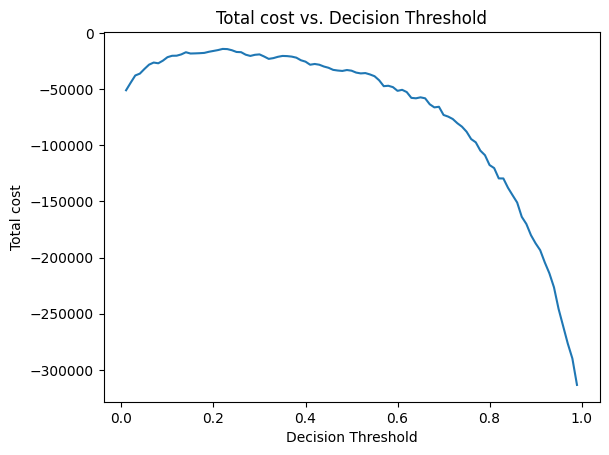

In [37]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(
    test=test_predictions_xgb_2, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'churn_2')

# EMP metric

In [38]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [39]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-73474.28257380932
-248262.284063745
EAP :  -55.746800131873535
EP :  -188.36288623956372


In [40]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-70831.45554823877
-248262.284063745
EAP :  -53.74162029456659
EP :  -188.36288623956372


# cost curves


In [41]:
unique_values = test_predictions_log['y_predicted'].unique()
print(unique_values)

[0 1]


In [42]:
total_fp_log = 0

for i in range(0,1315):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/1315
print( average_fp_log)

21799.100000000002
16.57726235741445


In [43]:
total_fn_log = 0

for i in range(0,1315):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/1315
print( average_fn_log)

52012.79999999999
39.55346007604562


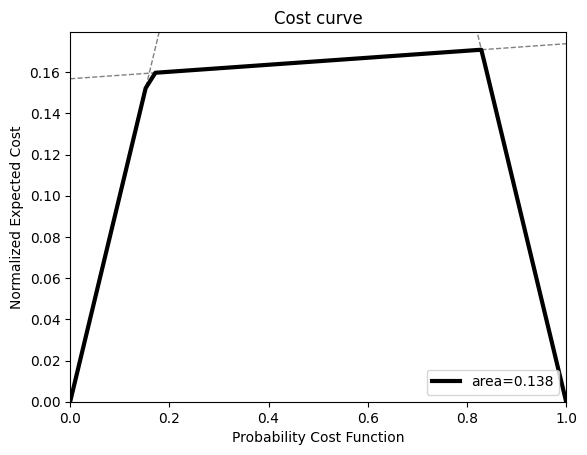

In [44]:



# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [45]:
total_fp_xgb = 0

for i in range(0,1315):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/1315
print( average_fp_xgb)

27261.59999999999
20.731254752851704


In [46]:
total_fn_xgb = 0

for i in range(0,1315):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/1315
print( average_fn_xgb)

51155.399999999994
38.901444866920144


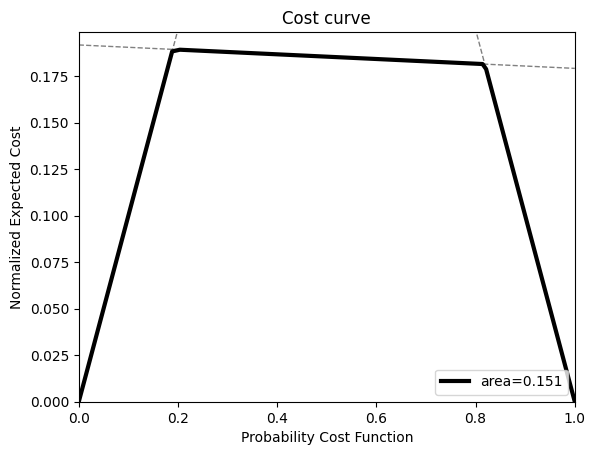

In [47]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the fraud detection cost and benefit matrices

# total cost 50% decision threshold

In [48]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_fraud = test.copy(deep=True)
test_predictions_log_fraud["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud.drop(y, axis=1))
test_predictions_log_fraud[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_fraud.drop(y, axis=1))[:, 1]
test_predictions_log_fraud[predicted_y_prob_col_name_log] = 1 - test_predictions_log_fraud[predicted_y_prob_col_name_log]
test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_fraud["customer_status"])
test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_fraud[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud['A'] = impute.fit_transform(
    (test_predictions_log_fraud["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_log_fraud["y_predicted"] = 1 - test_predictions_log_fraud["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud['instance_cost'] = test_predictions_log_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud['instance_cost'].sum()/len(test_predictions_log_fraud))

Test cost/loss = 4482.
 total cost/loss average :  3.4009104704097113


In [49]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_fraud = test.copy(deep=True)
test_predictions_xgb_fraud["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud.drop(y, axis=1))
test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud.drop(y, axis=1))[:, 1]
test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_fraud[predicted_y_prob_col_name_xgb]
test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_fraud["customer_status"])
test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_fraud[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_xgb_fraud["y_predicted"] = 1 - test_predictions_xgb_fraud["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud['instance_cost'] = test_predictions_xgb_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud['instance_cost'].sum()/len(test_predictions_xgb_fraud))

Test cost/loss = 4444.
 total cost/loss average :  3.371737481031867


In [50]:
print(test_predictions_xgb_fraud[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']])

     customer_status y_predicted_decoded         A  instance_cost
4879          Stayed             Churned  134900.0            0.0
1646          Stayed             Churned  139300.0            0.0
777           Stayed             Churned   40200.0            0.0
1163          Stayed             Churned  109500.0            0.0
130           Stayed             Churned   97600.0            0.0
...              ...                 ...       ...            ...
5340          Stayed             Churned  210100.0            0.0
2641         Churned              Stayed  176300.0            0.0
5796          Stayed              Stayed  188200.0            1.0
36            Stayed             Churned  179600.0            0.0
5716          Stayed             Churned   98900.0            0.0

[1318 rows x 4 columns]


# amc metric

Decision Threshold: 0.01, Test cost/loss = 706.15
Decision Threshold: 0.02, Test cost/loss = 796.65
Decision Threshold: 0.03, Test cost/loss = 745.65
Decision Threshold: 0.04, Test cost/loss = 715.65
Decision Threshold: 0.05, Test cost/loss = 688.65
Decision Threshold: 0.06, Test cost/loss = 802.00
Decision Threshold: 0.07, Test cost/loss = 785.00
Decision Threshold: 0.08, Test cost/loss = 823.20
Decision Threshold: 0.09, Test cost/loss = 1000.45
Decision Threshold: 0.10, Test cost/loss = 985.45
Decision Threshold: 0.11, Test cost/loss = 975.45
Decision Threshold: 0.12, Test cost/loss = 964.45
Decision Threshold: 0.13, Test cost/loss = 1008.70
Decision Threshold: 0.14, Test cost/loss = 1088.95
Decision Threshold: 0.15, Test cost/loss = 1132.10
Decision Threshold: 0.16, Test cost/loss = 1326.05
Decision Threshold: 0.17, Test cost/loss = 1401.45
Decision Threshold: 0.18, Test cost/loss = 1388.45
Decision Threshold: 0.19, Test cost/loss = 1460.50
Decision Threshold: 0.20, Test cost/loss =

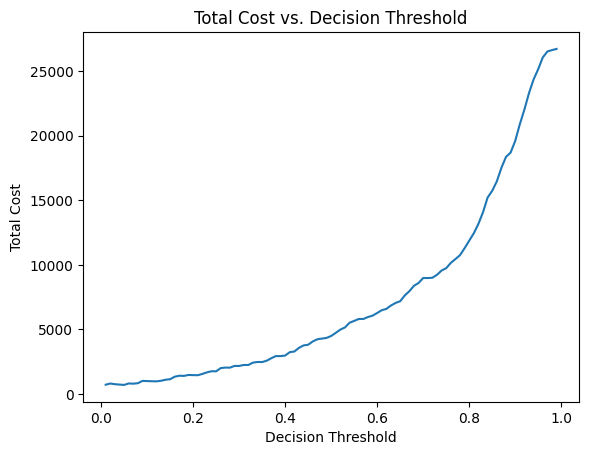

In [51]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(
    test=test_predictions_log_fraud, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 883.40
Decision Threshold: 0.02, Test cost/loss = 853.65
Decision Threshold: 0.03, Test cost/loss = 860.00
Decision Threshold: 0.04, Test cost/loss = 1018.90
Decision Threshold: 0.05, Test cost/loss = 1006.65
Decision Threshold: 0.06, Test cost/loss = 1009.05
Decision Threshold: 0.07, Test cost/loss = 1039.00
Decision Threshold: 0.08, Test cost/loss = 1243.70
Decision Threshold: 0.09, Test cost/loss = 1264.05
Decision Threshold: 0.10, Test cost/loss = 1243.05
Decision Threshold: 0.11, Test cost/loss = 1283.65
Decision Threshold: 0.12, Test cost/loss = 1375.60
Decision Threshold: 0.13, Test cost/loss = 1423.50
Decision Threshold: 0.14, Test cost/loss = 1406.50
Decision Threshold: 0.15, Test cost/loss = 1559.95
Decision Threshold: 0.16, Test cost/loss = 1608.15
Decision Threshold: 0.17, Test cost/loss = 1702.15
Decision Threshold: 0.18, Test cost/loss = 1810.00
Decision Threshold: 0.19, Test cost/loss = 1802.00
Decision Threshold: 0.20, Test cos

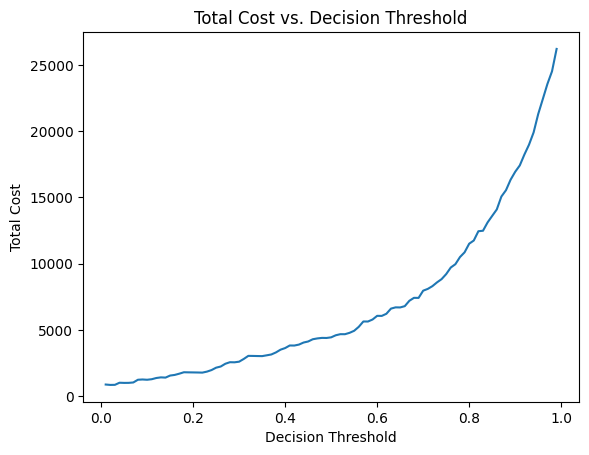

In [52]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(
    test=test_predictions_xgb_fraud, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'fraud')

# e-amc metric

In [53]:
test_predictions_log_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud")
test_predictions_xgb_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [54]:
print(test_predictions_log_fraud['EAP'].sum())
print(test_predictions_log_fraud['EP'].sum())


print('EAP : ', test_predictions_log_fraud['EAP'].sum()/len(test_predictions_log_fraud))
print('EP : ', test_predictions_log_fraud['EP'].sum()/len(test_predictions_log_fraud))

7331.418320782229
19418.461468412064
EAP :  5.562532868575287
EP :  14.733278807596406


In [55]:
print(test_predictions_xgb_fraud['EAP'].sum())
print(test_predictions_xgb_fraud['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud['EAP'].sum()/len(test_predictions_xgb_fraud))
print('EP : ', test_predictions_xgb_fraud['EP'].sum()/len(test_predictions_xgb_fraud))

6858.371741509438
19418.461468412064
EAP :  5.203620441205947
EP :  14.733278807596406


# MP at 50% threshold

In [56]:
MODEL_NAME = "log"
predicted_y_prob_col_name_log = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_log_fraud_2 = test.copy(deep=True)
test_predictions_log_fraud_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud_2.drop(y, axis=1))
test_predictions_log_fraud_2[predicted_y_prob_col_name_log] = best_pipeline_log_reg.predict_proba(test_predictions_log_fraud_2.drop(y, axis=1))[:, 1]
test_predictions_log_fraud_2[predicted_y_prob_col_name_log] = 1 - test_predictions_log_fraud_2[predicted_y_prob_col_name_log]
test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_log_fraud_2["customer_status"])
test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_log_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log_fraud_2["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_log_fraud_2["y_predicted"] = 1 - test_predictions_log_fraud_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud_2['instance_cost'] = test_predictions_log_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_log_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud_2['instance_cost'].sum()/len(test_predictions_log_fraud_2))

Test cost/loss = -4173.
 total cost/loss average :  -3.1664643399089525


In [57]:
MODEL_NAME = "xgb"
predicted_y_prob_col_name_xgb = f"{PREDICTED_Y_PROB_COLUMN_NAME_PREFIX}_{MODEL_NAME}"
test_predictions_xgb_fraud_2 = test.copy(deep=True)
test_predictions_xgb_fraud_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud_2.drop(y, axis=1))
test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb] = best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud_2.drop(y, axis=1))[:, 1]
test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb] = 1 - test_predictions_xgb_fraud_2[predicted_y_prob_col_name_xgb]
test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = fit_le.transform(test_predictions_xgb_fraud_2["customer_status"])
test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME] = 1 - test_predictions_xgb_fraud_2[TRUE_Y_ENCODED_COLUMN_NAME]
# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud_2['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud_2["monthly_charge"]*2000).to_frame())[:, 0]
test_predictions_xgb_fraud_2["y_predicted"] = 1 - test_predictions_xgb_fraud_2["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud_2['instance_cost'] = test_predictions_xgb_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row[TRUE_Y_ENCODED_COLUMN_NAME], row["A"]), axis=1)

test_predictions_xgb_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud_2[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud_2['instance_cost'].sum()/len(test_predictions_xgb_fraud_2))


Test cost/loss = -4137.
 total cost/loss average :  -3.138808801213961


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -333.15


Decision Threshold: 0.02, Test cost/loss = -426.65
Decision Threshold: 0.03, Test cost/loss = -375.65
Decision Threshold: 0.04, Test cost/loss = -345.65
Decision Threshold: 0.05, Test cost/loss = -318.65
Decision Threshold: 0.06, Test cost/loss = -434.00
Decision Threshold: 0.07, Test cost/loss = -417.00
Decision Threshold: 0.08, Test cost/loss = -456.20
Decision Threshold: 0.09, Test cost/loss = -636.45
Decision Threshold: 0.10, Test cost/loss = -621.45
Decision Threshold: 0.11, Test cost/loss = -611.45
Decision Threshold: 0.12, Test cost/loss = -600.45
Decision Threshold: 0.13, Test cost/loss = -645.70
Decision Threshold: 0.14, Test cost/loss = -727.95
Decision Threshold: 0.15, Test cost/loss = -772.10
Decision Threshold: 0.16, Test cost/loss = -969.05
Decision Threshold: 0.17, Test cost/loss = -1045.45
Decision Threshold: 0.18, Test cost/loss = -1032.45
Decision Threshold: 0.19, Test cost/loss = -1105.50
Decision Threshold: 0.20, Test cost/loss = -1093.50
Decision Threshold: 0.21, 

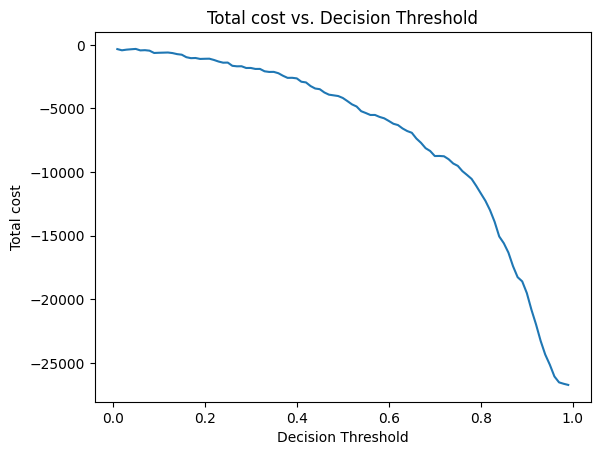

In [58]:
CB_COLUMN = 'A'
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(
    test=test_predictions_log_fraud_2, 
    best_pipeline=best_pipeline_log_reg, 
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME,
    cb_column=CB_COLUMN, 
    y_predicted_proba_col_name=predicted_y_prob_col_name_log,
    instance_dependent_cost_type = 'fraud_2')

Decision Threshold: 0.01, Test cost/loss = -510.40


Decision Threshold: 0.02, Test cost/loss = -481.65
Decision Threshold: 0.03, Test cost/loss = -490.00
Decision Threshold: 0.04, Test cost/loss = -651.90
Decision Threshold: 0.05, Test cost/loss = -640.65
Decision Threshold: 0.06, Test cost/loss = -644.05
Decision Threshold: 0.07, Test cost/loss = -675.00
Decision Threshold: 0.08, Test cost/loss = -882.70
Decision Threshold: 0.09, Test cost/loss = -904.05
Decision Threshold: 0.10, Test cost/loss = -883.05
Decision Threshold: 0.11, Test cost/loss = -924.65
Decision Threshold: 0.12, Test cost/loss = -1017.60
Decision Threshold: 0.13, Test cost/loss = -1066.50
Decision Threshold: 0.14, Test cost/loss = -1049.50
Decision Threshold: 0.15, Test cost/loss = -1204.95
Decision Threshold: 0.16, Test cost/loss = -1254.15
Decision Threshold: 0.17, Test cost/loss = -1349.15
Decision Threshold: 0.18, Test cost/loss = -1460.00
Decision Threshold: 0.19, Test cost/loss = -1452.00
Decision Threshold: 0.20, Test cost/loss = -1447.00
Decision Threshold: 0.

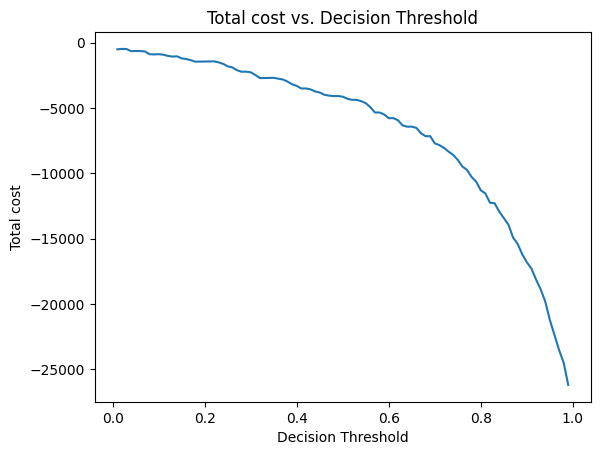

In [59]:
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(
    test=test_predictions_xgb_fraud_2, best_pipeline=best_pipeline_xgb,
    y_encoded_col_name=TRUE_Y_ENCODED_COLUMN_NAME, cb_column=CB_COLUMN, y_predicted_proba_col_name=predicted_y_prob_col_name_xgb,instance_dependent_cost_type = 'fraud_2')

# EMP-metric

In [60]:
test_predictions_log_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_log, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=CB_COLUMN, 
    predicted_proba_col_name=predicted_y_prob_col_name_xgb, 
    churn_label="Churned", 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [61]:
print(test_predictions_log_fraud_2['EAP'].sum())
print(test_predictions_log_fraud_2['EP'].sum())


print('EAP : ', test_predictions_log_fraud_2['EAP'].sum()/len(test_predictions_log_fraud_2))
print('EP : ', test_predictions_log_fraud_2['EP'].sum()/len(test_predictions_log_fraud_2))

-7063.19278158547
-19312.3848226143
EAP :  -5.359023354768945
EP :  -14.652795768296132


In [62]:
print(test_predictions_xgb_fraud_2['EAP'].sum())
print(test_predictions_xgb_fraud_2['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud_2['EAP'].sum()/len(test_predictions_xgb_fraud_2))
print('EP : ', test_predictions_xgb_fraud_2['EP'].sum()/len(test_predictions_xgb_fraud_2))

-6583.14713600874
-19312.3848226143
EAP :  -4.994800558428483
EP :  -14.652795768296132


# cost curves

In [63]:
total_fp_log_2 = 0

for i in range(0,1315):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_log_fraud['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_fraud['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/1315
print( average_fp_log_2)

148
0.11254752851711027


In [64]:
total_fn_log_2 = 0

for i in range(0,1315):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_log_fraud['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_fraud['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/1315
print( average_fn_log_2)

4334.4
3.296121673003802


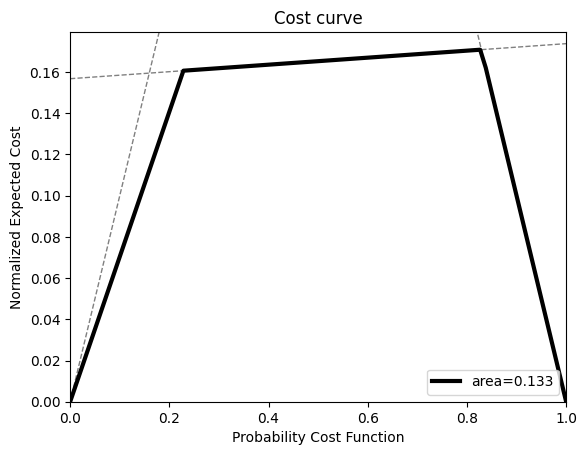

In [65]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [66]:
total_fp_xgb_2 = 0

for i in range(0,1315):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_fraud['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/1315
print( average_fp_xgb_2)

181
0.1376425855513308


In [67]:
total_fn_xgb_2 = 0

for i in range(0,1315):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_fraud['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/1315
print( average_fn_xgb_2)

4262.949999999999
3.241787072243345


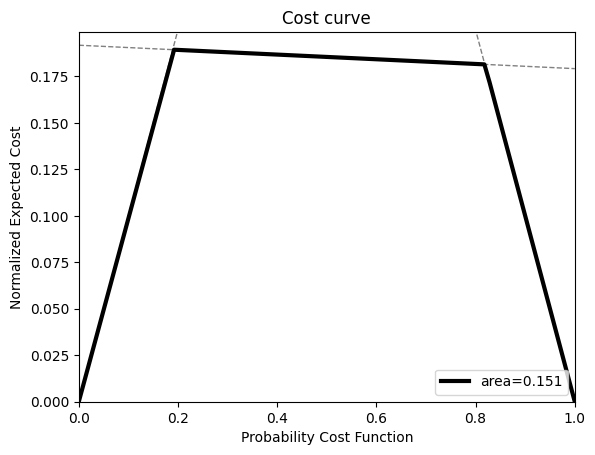

In [68]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()